<a href="https://colab.research.google.com/github/rishi-latchmepersad/tensorflow_tutorials/blob/main/getting_started_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import numpy as np
from keras import layers as L
keras.utils.set_random_seed(42) # set seed to ensure reproducibility
from keras import ops
!pip install --upgrade keras
!pip install --upgrade keras-cv
!pip install --upgrade keras-hub
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.9/947.9 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: keras-hub
    Found existing installation: keras-hub 0.21.1
    Uninstalling keras-hub-0.21.1:
      Successfully uninstalled keras-hub-0.21.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.21.1 requires keras-hub==0.21.1, but you have keras-hub 0.22.2 which is incompatible.


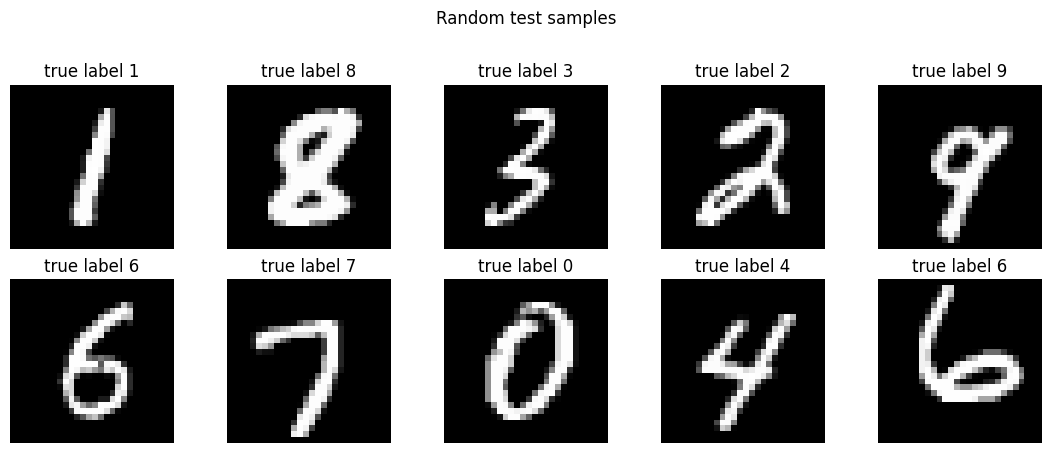

In [8]:
# the mnist dataset is a large dataset of handwritten digits from 0-9, commonly used to evaluate computer vision tasks
# we first load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# let's plot 10 random images from our test dataset, to see what we're trying to predict
import matplotlib.pyplot as plt

# first we sample 10 random indices from the test set
idx = np.random.choice(len(x_test), size=10, replace=False)

# then we grab the images and labels for those indices.
imgs   = x_test[idx]      # shape (10, H, W, C) or (10, H, W)
labels = y_test[idx]      # shape (10,)

# ensure images are 4D for prediction (N, H, W, C). If they’re (N, H, W) add the channel axis.
if imgs.ndim == 3:
    imgs = imgs[..., None]

# then plot a 2×5 grid, labeling each tile with the predicted class (and the true one if wrong).
rows, cols = 2, 5
plt.figure(figsize=(cols * 2.2, rows * 2.2))
for i, (img, y_true) in enumerate(zip(imgs, labels)):
    plt.subplot(rows, cols, i + 1)

    # Display: grayscale if single channel, RGB otherwise
    if img.shape[-1] == 1:
        # Pick display range based on dtype for nicer contrast
        vmin, vmax = (0, 255) if img.dtype == np.uint8 else (0, 1)
        plt.imshow(img.squeeze(), cmap="gray", vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img)

    title = f"true label {int(y_true)}"
    plt.title(title)
    plt.axis("off")

plt.suptitle("Random test samples", y=1.02)
plt.tight_layout()
plt.show()

In [2]:
# normalize the images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# the mnist dataset provides a set of 28x28 greyscale images, but it doesn't explicitly set the number of channels to be 1 (greyscale)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
# so we add the extra dimension to the end for use in the later convolution layers
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("y_train shape:", x_test.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)
x_train shape: (60000, 28, 28, 1)
y_train shape: (10000, 28, 28, 1)
60000 train samples
10000 test samples


# Core Deep Learning Model Families (cheat sheet)

## MLP / Feed-Forward
- **Use for:** tabular data, small classifiers, quick baselines  
- **Idea:** dense layers on flattened inputs  
- **Keras layers:** `Dense`, `Dropout`  
- **TinyML notes:** very compact, but loses spatial or temporal structure

## CNNs

### 2D CNN
- **Use for:** images, small vision tasks like digits or gauges  
- **Idea:** local receptive fields with shared weights  
- **Keras layers:** `Conv2D`, `DepthwiseConv2D`, `MaxPool2D`, `GlobalAveragePooling2D`  
- **TinyML notes:** the workhorse with strong TFLite Micro support

### 1D CNN
- **Use for:** time series, sensor streams, audio features  
- **Idea:** same as 2D but along a single axis  
- **Keras layers:** `Conv1D`, `GlobalAveragePooling1D`  
- **TinyML notes:** fast and memory friendly for forecasting

### Depthwise-separable CNN
- **Use for:** mobile or MCU efficiency with good accuracy  
- **Idea:** depthwise conv per channel, then pointwise `1×1`  
- **Keras layers:** `DepthwiseConv2D`, `Conv2D` with `kernel_size=1`  
- **TinyML notes:** big savings in parameters and MACs

## Residual CNNs and Inverted Residuals
- **Use for:** deeper small models that train stably  
- **Idea:** skip connections, MobileNetV2 style bottlenecks  
- **Keras layers:** `Add` plus the usual convs  
- **TinyML notes:** small extra RAM for the skip, usually worth it

## TCN, Temporal Convolutional Networks
- **Use for:** forecasting and sequence modeling without recurrence  
- **Idea:** dilated causal `Conv1D` for long context  
- **Keras layers:** `Conv1D` with `dilation_rate`, `padding="causal"`  
- **TinyML notes:** only conv ops, very deployment friendly

## RNN / LSTM / GRU
- **Use for:** sequences where order and long memory matter  
- **Idea:** recurrent state flows step to step  
- **Keras layers:** `SimpleRNN`, `LSTM`, `GRU`  
- **TinyML notes:** heavier than Conv1D or TCN; TFLite support exists, TFLite Micro is tighter

## Transformers
- **Use for:** language, ViT, some multimodal tasks  
- **Idea:** self-attention mixes all positions  
- **Keras layers:** `MultiHeadAttention`, `LayerNormalization`, `Dense`  
- **TinyML notes:** memory hungry; tiny variants exist but are harder on MCUs

## Autoencoders (AE) and Variational AEs
- **Use for:** compression, denoising, anomaly detection  
- **Idea:** encode to a latent, reconstruct the input  
- **Keras layers:** same CNN or MLP blocks plus a reconstruction head  
- **TinyML notes:** small AEs are fine; VAEs add stochastic parts and extra cost

## GANs
- **Use for:** data synthesis, augmentation  
- **Idea:** generator versus discriminator  
- **TinyML notes:** training off device; inference can be heavy

## Diffusion Models
- **Use for:** high quality generative images or audio  
- **Idea:** iterative denoising from noise  
- **TinyML notes:** far too heavy for microcontrollers

## Graph Neural Networks (GNNs)
- **Use for:** graphs, molecules, road networks  
- **Idea:** message passing over nodes and edges  
- **TinyML notes:** niche and often requires custom ops

---

In [3]:
# now we build a model to predict the digit using the keras functional API
def build_functional_model(input_shape, num_classes):
    """
    Build a small VGG-style CNN using the Functional API.
    input_shape: tuple (H, W, C), for MNIST often (28, 28, 1)
    num_classes: number of output classes for classification (often 10 for MNIST)
    """
    inputs = keras.Input(shape=input_shape)         # Define the symbolic input tensor for the computation graph

    # First convolutional block: two 3×3 convs
    # Note: padding='valid' is the default and shrinks H and W by 2 each conv.
    # If we want to keep spatial size, set padding='same'.
    x = L.Conv2D(64, (3, 3), activation="relu")(inputs)   # Extract local features with 64 filters, add nonlinearity
    x = L.Conv2D(64, (3, 3), activation="relu")(x)        # Stack another 3×3 to expand receptive field with modest params
    x = L.MaxPooling2D((2, 2))(x)                         # Downsample by 2, reduce compute, gain some translation invariance

    # Second convolutional block: increase channel depth as resolution drops
    x = L.Conv2D(128, (3, 3), activation="relu")(x)       # Learn richer features at lower spatial resolution
    x = L.Conv2D(128, (3, 3), activation="relu")(x)       # Another 3×3 for more expressive power without huge kernels

    # Classifier head: make features compact, regularize, then classify
    x = L.GlobalAveragePooling2D()(x)                     # Average each feature map over H and W, get a 128-D vector; avoids large Dense layers
    x = L.Dropout(0.5)(x)                                 # Randomly drop activations during training, reduce overfitting; inactive at inference

    outputs = L.Dense(num_classes, activation="softmax")(x)  # Map to class probabilities for single-label multiclass tasks

    return keras.Model(inputs=inputs,                      # Assemble inputs and outputs into a Model object
                       outputs=outputs,
                       name="mnist_predict_digits")


In [4]:
# call the function to build the model. we use 10 classes since we have digits 0-9, and use the first training element to set the input shape
model = build_functional_model(input_shape=x_train.shape[1:], num_classes=10)
# compile the model to set the rules for fitting and evaluating the model.
# adam is usually a good default optimizer (it uses SGD)
# we use sparse categorical crossentropy for the loss since we have multiple output classes which are integers (0-9)
# and we want to report on accuracy
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()
## plot the model graph if we need it
# keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

Model: "mnist_predict_digits"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,298 (1016.79 KB)

 Trainable params: 260,298 (1016.79 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# now we actually train our model using our test data
# first we define callbacks that make training safer and faster.
callbacks = [
    # EarlyStopping watches validation loss; if it stops improving for 'patience' epochs,
    # training halts early to prevent overfitting and to save time.
    # restore_best_weights=True puts the model back to the epoch with the lowest val_loss.
    keras.callbacks.EarlyStopping(
        monitor="val_loss",     # default; explicit for clarity
        patience=5,             # wait 5 epochs without improvement
        restore_best_weights=True
    ),

    # ReduceLROnPlateau lowers the learning rate when validation loss stalls.
    # This often lets the optimizer settle into a better minimum after the fast phase.
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,             # cut LR in half each time the plateau is detected
        patience=2,             # wait 2 stagnant epochs before reducing LR
        min_lr=1e-5             # do not shrink below this floor
    ),
]

# then we train/fit the model.
history = model.fit(
    x_train, y_train,
    validation_split=0.1,       # hold out 10% of training data for validation;
                                # callbacks look at this, not the test set, to avoid leakage
    epochs=20,                  # maximum number of passes; EarlyStopping may stop earlier
    batch_size=128,             # tradeoff between speed and generalization; 128 is a solid default
    callbacks=callbacks,               # attach the callbacks defined above
    verbose=2                   # concise logs per epoch; change to 1 or 0 if you prefer
)

# then evaluate once on the unseen test set.
# This gives an unbiased estimate of generalization, since we did not peek at it during training.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

# finally report results for our model in a compact way.
print(f"Test loss: {test_loss:.4f}  |  Test accuracy: {test_acc:.4f}")

Epoch 1/20
422/422 - 25s - 58ms/step - accuracy: 0.7500 - loss: 0.7348 - val_accuracy: 0.9620 - val_loss: 0.1447 - learning_rate: 1.0000e-03
Epoch 2/20
422/422 - 24s - 56ms/step - accuracy: 0.9389 - loss: 0.2047 - val_accuracy: 0.9785 - val_loss: 0.0831 - learning_rate: 1.0000e-03
Epoch 3/20
422/422 - 4s - 11ms/step - accuracy: 0.9584 - loss: 0.1384 - val_accuracy: 0.9828 - val_loss: 0.0618 - learning_rate: 1.0000e-03
Epoch 4/20
422/422 - 5s - 11ms/step - accuracy: 0.9661 - loss: 0.1157 - val_accuracy: 0.9863 - val_loss: 0.0509 - learning_rate: 1.0000e-03
Epoch 5/20
422/422 - 5s - 12ms/step - accuracy: 0.9718 - loss: 0.0961 - val_accuracy: 0.9882 - val_loss: 0.0432 - learning_rate: 1.0000e-03
Epoch 6/20
422/422 - 5s - 11ms/step - accuracy: 0.9761 - loss: 0.0806 - val_accuracy: 0.9890 - val_loss: 0.0396 - learning_rate: 1.0000e-03
Epoch 7/20
422/422 - 5s - 11ms/step - accuracy: 0.9777 - loss: 0.0748 - val_accuracy: 0.9900 - val_loss: 0.0362 - learning_rate: 1.0000e-03
Epoch 8/20
422/422

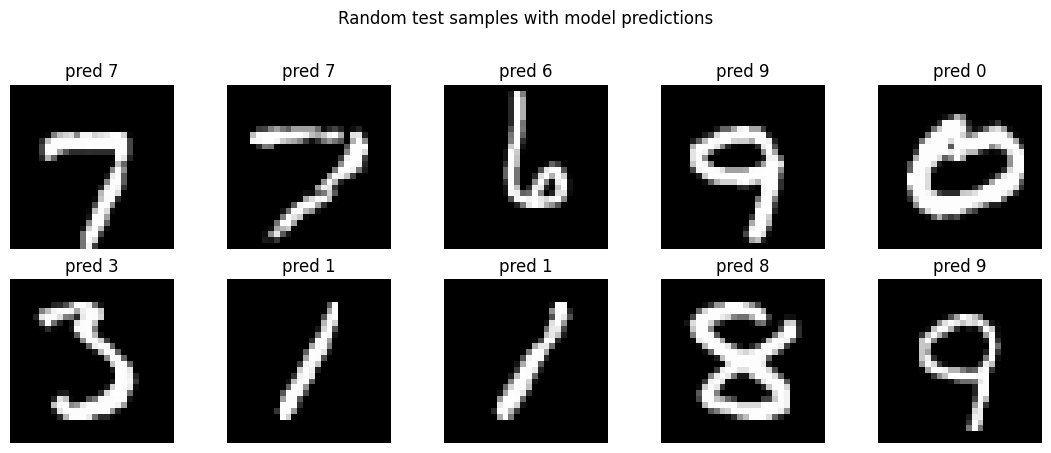

In [7]:
# plot 10 images from our test dataset to help us visualize how our model is performing

# first we sample 10 random indices from the test set
idx = np.random.choice(len(x_test), size=10, replace=False)

# then we grab the images and labels for those indices.
imgs   = x_test[idx]      # shape (10, H, W, C) or (10, H, W)
labels = y_test[idx]      # shape (10,)

# ensure images are 4D for prediction (N, H, W, C). If they’re (N, H, W) add the channel axis.
if imgs.ndim == 3:
    imgs = imgs[..., None]

# then run the model to get class probabilities, and take argmax → predicted class ID per image.
probs = model.predict(imgs, verbose=0)      # shape (10, num_classes)
preds = probs.argmax(axis=1)

# then plot a 2×5 grid, labeling each tile with the predicted class (and the true one if wrong).
rows, cols = 2, 5
plt.figure(figsize=(cols * 2.2, rows * 2.2))
for i, (img, y_true, y_pred) in enumerate(zip(imgs, labels, preds)):
    plt.subplot(rows, cols, i + 1)

    # Display: grayscale if single channel, RGB otherwise
    if img.shape[-1] == 1:
        # Pick display range based on dtype for nicer contrast
        vmin, vmax = (0, 255) if img.dtype == np.uint8 else (0, 1)
        plt.imshow(img.squeeze(), cmap="gray", vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img)

    ok = int(y_true) == int(y_pred)
    title = f"pred {int(y_pred)}" if ok else f"pred {int(y_pred)} (true {int(y_true)})"
    plt.title(title)
    plt.axis("off")

plt.suptitle("Random test samples with model predictions", y=1.02)
plt.tight_layout()
plt.show()
